# DIP Training for Denoising with Callbacks

testing the first python implementations

In [1]:
!nvidia-smi

Sun May  9 19:07:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 307...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P0    22W /  N/A |    451MiB /  7982MiB |     15%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf

import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import copy
%config Completer.use_jedi = False

In [3]:
from skimage.metrics import peak_signal_noise_ratio #import compare_psnr

In [4]:
import sys
sys.path.append("../src")
sys.path.append("../")

In [5]:
from model.skip_net import *
from model.unet import *
from utils.data_processing import *
from utils.data_plotting import *
from training_pipeline.dip_method import *

In [6]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Data Processing

## Input image and noisy image

In [7]:
sigma = 25
sigma_ = sigma/255.
img = load_image("../data/original/F16_GT.png")
img_noise = get_noise_image(img, sigma_)

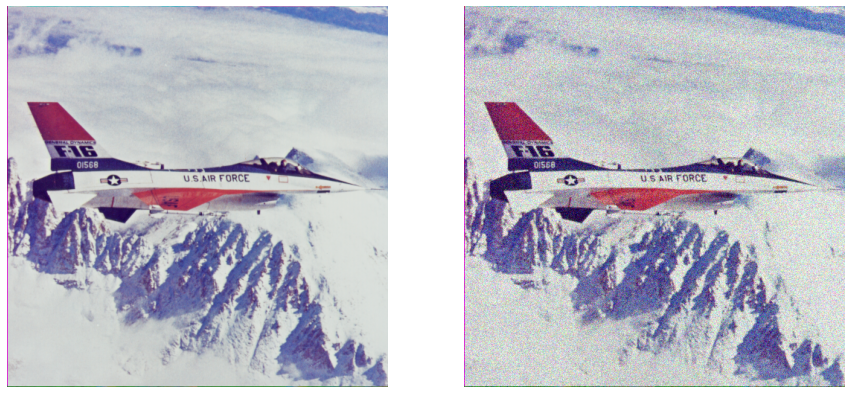

In [8]:
plot_images([img, img_noise])

In [9]:
image_information(img)
image_information(img_noise)

dtype:  float32 , type:  <class 'numpy.ndarray'>
size:  (512, 512, 3) , range: 0.0 - 0.9176470637321472
dtype:  float32 , type:  <class 'numpy.ndarray'>
size:  (512, 512, 3) , range: 0.0 - 1.0


In [10]:
print("PSNR = ", peak_signal_noise_ratio(img_noise, img))

PSNR =  20.364495574860335


## Network input

In [11]:
net_input = get_network_input((1,512,512,32))
image_information(net_input)

dtype:  <dtype: 'float32'> , type:  <class 'tensorflow.python.framework.ops.EagerTensor'>
size:  (1, 512, 512, 32) , range: 0.0 - 0.09999998658895493


In [12]:
y = convert_to_tf_tensor(img_noise)
y_val = convert_to_tf_tensor(img)

# Model

In [13]:
from src.model.CustomModel import CustomModel

In [14]:
model = skip_net()

In [15]:
model.summary()

Model: "custom_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(1, 512, 512, 32)]  0                                            
__________________________________________________________________________________________________
reflection_padding2d (Reflectio (1, 514, 514, 32)    0           input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (1, 256, 256, 128)   36992       reflection_padding2d[0][0]       
__________________________________________________________________________________________________
batch_normalization (BatchNorma (1, 256, 256, 128)   512         conv2d[0][0]                     
_______________________________________________________________________________________

In [35]:
model.reg_noise_std

0.03333333333333333

# Training

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_psnr', patience=100, 
                                                  verbose=1, mode="max")
cbs = [tf.keras.callbacks.ModelCheckpoint(
                                    filepath="test.hdf5",
                                    save_weights_only=True,
                                    monitor='val_psnr',
                                    mode='max',
                                    save_best_only=True,
                                    verbose=0),
       early_stopping
]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, 
                                     epsilon=1e-08, amsgrad=False,name='Adam')

In [30]:
model.compile(optimizer=optimizer)

In [31]:
num_iter = 3000

In [32]:
history = model.fit(x = net_input,
          y = y,
          epochs=num_iter,
          callbacks=cbs,
          validation_data = (net_input, y_val),
          verbose=1)

Epoch 1/3000
1/1 [==============================] - 3s 3s/step - loss: 0.0098 - psnr: 20.1099 - ssim: 0.2382 - val_loss: 0.1247 - val_psnr: 9.0421 - val_ssim: 0.4659
Epoch 2/3000
1/1 [==============================] - 0s 173ms/step - loss: 0.0900 - psnr: 10.4578 - ssim: 0.1304 - val_loss: 0.0348 - val_psnr: 14.5884 - val_ssim: 0.6568
Epoch 3/3000
1/1 [==============================] - 0s 182ms/step - loss: 0.0349 - psnr: 14.5694 - ssim: 0.1256 - val_loss: 0.0272 - val_psnr: 15.6498 - val_ssim: 0.6458
Epoch 4/3000
1/1 [==============================] - 0s 170ms/step - loss: 0.0338 - psnr: 14.7065 - ssim: 0.1346 - val_loss: 0.0204 - val_psnr: 16.8942 - val_ssim: 0.7157
Epoch 5/3000
1/1 [==============================] - 0s 168ms/step - loss: 0.0259 - psnr: 15.8740 - ssim: 0.1644 - val_loss: 0.0189 - val_psnr: 17.2300 - val_ssim: 0.7316
Epoch 6/3000
1/1 [==============================] - 0s 174ms/step - loss: 0.0218 - psnr: 16.6234 - ssim: 0.1587 - val_loss: 0.0176 - val_psnr: 17.5418 - v

Epoch 49/3000
1/1 [==============================] - 0s 280ms/step - loss: 0.0132 - psnr: 18.8066 - ssim: 0.1742 - val_loss: 0.0035 - val_psnr: 24.5358 - val_ssim: 0.7815
Epoch 50/3000
1/1 [==============================] - 0s 159ms/step - loss: 0.0130 - psnr: 18.8444 - ssim: 0.1741 - val_loss: 0.0035 - val_psnr: 24.5700 - val_ssim: 0.7818
Epoch 51/3000
1/1 [==============================] - 0s 155ms/step - loss: 0.0131 - psnr: 18.8439 - ssim: 0.1758 - val_loss: 0.0036 - val_psnr: 24.4519 - val_ssim: 0.7830
Epoch 52/3000
1/1 [==============================] - 0s 167ms/step - loss: 0.0130 - psnr: 18.8723 - ssim: 0.1766 - val_loss: 0.0035 - val_psnr: 24.5320 - val_ssim: 0.7838
Epoch 53/3000
1/1 [==============================] - 0s 171ms/step - loss: 0.0130 - psnr: 18.8770 - ssim: 0.1755 - val_loss: 0.0035 - val_psnr: 24.6046 - val_ssim: 0.7846
Epoch 54/3000
1/1 [==============================] - 0s 155ms/step - loss: 0.0129 - psnr: 18.9090 - ssim: 0.1754 - val_loss: 0.0035 - val_psnr: 2

Epoch 97/3000
1/1 [==============================] - 0s 179ms/step - loss: 0.0118 - psnr: 19.2701 - ssim: 0.1934 - val_loss: 0.0026 - val_psnr: 25.7810 - val_ssim: 0.8146
Epoch 98/3000
1/1 [==============================] - 0s 170ms/step - loss: 0.0118 - psnr: 19.2939 - ssim: 0.1939 - val_loss: 0.0026 - val_psnr: 25.8553 - val_ssim: 0.8151
Epoch 99/3000
1/1 [==============================] - 0s 168ms/step - loss: 0.0118 - psnr: 19.2821 - ssim: 0.1935 - val_loss: 0.0025 - val_psnr: 25.9764 - val_ssim: 0.8161
Epoch 100/3000
1/1 [==============================] - 0s 174ms/step - loss: 0.0117 - psnr: 19.3060 - ssim: 0.1941 - val_loss: 0.0025 - val_psnr: 26.0312 - val_ssim: 0.8168
Epoch 101/3000
1/1 [==============================] - 0s 177ms/step - loss: 0.0118 - psnr: 19.2951 - ssim: 0.1938 - val_loss: 0.0026 - val_psnr: 25.8488 - val_ssim: 0.8164
Epoch 102/3000
1/1 [==============================] - 0s 178ms/step - loss: 0.0117 - psnr: 19.3197 - ssim: 0.1951 - val_loss: 0.0025 - val_psnr

Epoch 145/3000
1/1 [==============================] - 0s 165ms/step - loss: 0.0112 - psnr: 19.5127 - ssim: 0.2007 - val_loss: 0.0021 - val_psnr: 26.7649 - val_ssim: 0.8294
Epoch 146/3000
1/1 [==============================] - 0s 171ms/step - loss: 0.0112 - psnr: 19.5206 - ssim: 0.2035 - val_loss: 0.0022 - val_psnr: 26.6190 - val_ssim: 0.8309
Epoch 147/3000
1/1 [==============================] - 0s 162ms/step - loss: 0.0111 - psnr: 19.5353 - ssim: 0.2037 - val_loss: 0.0022 - val_psnr: 26.6534 - val_ssim: 0.8305
Epoch 148/3000
1/1 [==============================] - 0s 156ms/step - loss: 0.0111 - psnr: 19.5460 - ssim: 0.2026 - val_loss: 0.0022 - val_psnr: 26.5769 - val_ssim: 0.8297
Epoch 149/3000
1/1 [==============================] - 0s 174ms/step - loss: 0.0111 - psnr: 19.5525 - ssim: 0.2040 - val_loss: 0.0022 - val_psnr: 26.6200 - val_ssim: 0.8308
Epoch 150/3000
1/1 [==============================] - 0s 161ms/step - loss: 0.0110 - psnr: 19.5782 - ssim: 0.2034 - val_loss: 0.0021 - val_p

Epoch 193/3000
1/1 [==============================] - 0s 173ms/step - loss: 0.0107 - psnr: 19.6912 - ssim: 0.2114 - val_loss: 0.0020 - val_psnr: 26.9776 - val_ssim: 0.8419
Epoch 194/3000
1/1 [==============================] - 0s 175ms/step - loss: 0.0107 - psnr: 19.6987 - ssim: 0.2097 - val_loss: 0.0019 - val_psnr: 27.3090 - val_ssim: 0.8431
Epoch 195/3000
1/1 [==============================] - 0s 176ms/step - loss: 0.0107 - psnr: 19.7192 - ssim: 0.2097 - val_loss: 0.0019 - val_psnr: 27.2765 - val_ssim: 0.8424
Epoch 196/3000
1/1 [==============================] - 0s 168ms/step - loss: 0.0107 - psnr: 19.7212 - ssim: 0.2109 - val_loss: 0.0019 - val_psnr: 27.2081 - val_ssim: 0.8427
Epoch 197/3000
1/1 [==============================] - 0s 176ms/step - loss: 0.0107 - psnr: 19.7239 - ssim: 0.2120 - val_loss: 0.0020 - val_psnr: 26.9758 - val_ssim: 0.8424
Epoch 198/3000
1/1 [==============================] - 0s 161ms/step - loss: 0.0107 - psnr: 19.7265 - ssim: 0.2119 - val_loss: 0.0020 - val_p

Epoch 241/3000
1/1 [==============================] - 0s 162ms/step - loss: 0.0105 - psnr: 19.7930 - ssim: 0.2180 - val_loss: 0.0017 - val_psnr: 27.7298 - val_ssim: 0.8496
Epoch 242/3000
1/1 [==============================] - 0s 169ms/step - loss: 0.0105 - psnr: 19.8059 - ssim: 0.2173 - val_loss: 0.0018 - val_psnr: 27.4144 - val_ssim: 0.8491
Epoch 243/3000
1/1 [==============================] - 0s 186ms/step - loss: 0.0105 - psnr: 19.7915 - ssim: 0.2160 - val_loss: 0.0017 - val_psnr: 27.6026 - val_ssim: 0.8515
Epoch 244/3000
1/1 [==============================] - 0s 167ms/step - loss: 0.0105 - psnr: 19.7922 - ssim: 0.2146 - val_loss: 0.0016 - val_psnr: 27.9835 - val_ssim: 0.8522
Epoch 245/3000
1/1 [==============================] - 0s 181ms/step - loss: 0.0105 - psnr: 19.7903 - ssim: 0.2161 - val_loss: 0.0015 - val_psnr: 28.1515 - val_ssim: 0.8525
Epoch 246/3000
1/1 [==============================] - 0s 165ms/step - loss: 0.0105 - psnr: 19.8056 - ssim: 0.2187 - val_loss: 0.0017 - val_p

Epoch 289/3000
1/1 [==============================] - 0s 170ms/step - loss: 0.0103 - psnr: 19.8556 - ssim: 0.2202 - val_loss: 0.0014 - val_psnr: 28.4256 - val_ssim: 0.8575
Epoch 290/3000
1/1 [==============================] - 0s 170ms/step - loss: 0.0103 - psnr: 19.8587 - ssim: 0.2197 - val_loss: 0.0015 - val_psnr: 28.3699 - val_ssim: 0.8571
Epoch 291/3000
1/1 [==============================] - 0s 172ms/step - loss: 0.0103 - psnr: 19.8564 - ssim: 0.2207 - val_loss: 0.0015 - val_psnr: 28.1408 - val_ssim: 0.8553
Epoch 292/3000
1/1 [==============================] - 0s 167ms/step - loss: 0.0103 - psnr: 19.8597 - ssim: 0.2212 - val_loss: 0.0015 - val_psnr: 28.3084 - val_ssim: 0.8553
Epoch 293/3000
1/1 [==============================] - 0s 170ms/step - loss: 0.0103 - psnr: 19.8673 - ssim: 0.2215 - val_loss: 0.0014 - val_psnr: 28.3889 - val_ssim: 0.8563
Epoch 294/3000
1/1 [==============================] - 0s 163ms/step - loss: 0.0103 - psnr: 19.8646 - ssim: 0.2201 - val_loss: 0.0014 - val_p

Epoch 337/3000
1/1 [==============================] - 0s 166ms/step - loss: 0.0102 - psnr: 19.9135 - ssim: 0.2241 - val_loss: 0.0014 - val_psnr: 28.5816 - val_ssim: 0.8600
Epoch 338/3000
1/1 [==============================] - 0s 163ms/step - loss: 0.0102 - psnr: 19.9063 - ssim: 0.2249 - val_loss: 0.0014 - val_psnr: 28.4946 - val_ssim: 0.8597
Epoch 339/3000
1/1 [==============================] - 0s 166ms/step - loss: 0.0102 - psnr: 19.9047 - ssim: 0.2238 - val_loss: 0.0014 - val_psnr: 28.5990 - val_ssim: 0.8591
Epoch 340/3000
1/1 [==============================] - 0s 176ms/step - loss: 0.0102 - psnr: 19.9122 - ssim: 0.2235 - val_loss: 0.0014 - val_psnr: 28.4523 - val_ssim: 0.8596
Epoch 341/3000
1/1 [==============================] - 0s 161ms/step - loss: 0.0102 - psnr: 19.9117 - ssim: 0.2235 - val_loss: 0.0015 - val_psnr: 28.3786 - val_ssim: 0.8601
Epoch 342/3000
1/1 [==============================] - 0s 173ms/step - loss: 0.0102 - psnr: 19.9164 - ssim: 0.2238 - val_loss: 0.0014 - val_p

Epoch 385/3000
1/1 [==============================] - 0s 160ms/step - loss: 0.0101 - psnr: 19.9473 - ssim: 0.2261 - val_loss: 0.0014 - val_psnr: 28.5758 - val_ssim: 0.8624
Epoch 386/3000
1/1 [==============================] - 0s 162ms/step - loss: 0.0101 - psnr: 19.9573 - ssim: 0.2272 - val_loss: 0.0014 - val_psnr: 28.6034 - val_ssim: 0.8623
Epoch 387/3000
1/1 [==============================] - 0s 161ms/step - loss: 0.0101 - psnr: 19.9472 - ssim: 0.2264 - val_loss: 0.0013 - val_psnr: 28.7442 - val_ssim: 0.8620
Epoch 388/3000
1/1 [==============================] - 0s 156ms/step - loss: 0.0101 - psnr: 19.9524 - ssim: 0.2259 - val_loss: 0.0014 - val_psnr: 28.6731 - val_ssim: 0.8623
Epoch 389/3000
1/1 [==============================] - 0s 152ms/step - loss: 0.0101 - psnr: 19.9544 - ssim: 0.2270 - val_loss: 0.0014 - val_psnr: 28.5021 - val_ssim: 0.8620
Epoch 390/3000
1/1 [==============================] - 0s 161ms/step - loss: 0.0101 - psnr: 19.9598 - ssim: 0.2282 - val_loss: 0.0014 - val_p

Epoch 433/3000
1/1 [==============================] - 0s 153ms/step - loss: 0.0101 - psnr: 19.9690 - ssim: 0.2301 - val_loss: 0.0013 - val_psnr: 28.7578 - val_ssim: 0.8632
Epoch 434/3000
1/1 [==============================] - 0s 173ms/step - loss: 0.0101 - psnr: 19.9675 - ssim: 0.2270 - val_loss: 0.0015 - val_psnr: 28.3611 - val_ssim: 0.8624
Epoch 435/3000
1/1 [==============================] - 0s 182ms/step - loss: 0.0100 - psnr: 19.9880 - ssim: 0.2293 - val_loss: 0.0015 - val_psnr: 28.3090 - val_ssim: 0.8623
Epoch 436/3000
1/1 [==============================] - 0s 155ms/step - loss: 0.0100 - psnr: 19.9800 - ssim: 0.2294 - val_loss: 0.0013 - val_psnr: 28.9388 - val_ssim: 0.8642
Epoch 437/3000
1/1 [==============================] - 0s 182ms/step - loss: 0.0100 - psnr: 19.9935 - ssim: 0.2288 - val_loss: 0.0013 - val_psnr: 28.8384 - val_ssim: 0.8648
Epoch 438/3000
1/1 [==============================] - 0s 183ms/step - loss: 0.0100 - psnr: 19.9821 - ssim: 0.2302 - val_loss: 0.0013 - val_p

Epoch 481/3000
1/1 [==============================] - 0s 166ms/step - loss: 0.0100 - psnr: 20.0145 - ssim: 0.2315 - val_loss: 0.0014 - val_psnr: 28.6908 - val_ssim: 0.8640
Epoch 482/3000
1/1 [==============================] - 0s 172ms/step - loss: 0.0100 - psnr: 20.0134 - ssim: 0.2324 - val_loss: 0.0013 - val_psnr: 28.7394 - val_ssim: 0.8643
Epoch 483/3000
1/1 [==============================] - 0s 195ms/step - loss: 0.0100 - psnr: 20.0173 - ssim: 0.2310 - val_loss: 0.0012 - val_psnr: 29.1016 - val_ssim: 0.8655
Epoch 484/3000
1/1 [==============================] - 0s 182ms/step - loss: 0.0100 - psnr: 20.0156 - ssim: 0.2301 - val_loss: 0.0012 - val_psnr: 29.0589 - val_ssim: 0.8651
Epoch 485/3000
1/1 [==============================] - 0s 171ms/step - loss: 0.0100 - psnr: 20.0203 - ssim: 0.2324 - val_loss: 0.0013 - val_psnr: 28.7899 - val_ssim: 0.8650
Epoch 486/3000
1/1 [==============================] - 0s 186ms/step - loss: 0.0099 - psnr: 20.0236 - ssim: 0.2331 - val_loss: 0.0012 - val_p

Epoch 529/3000
1/1 [==============================] - 0s 173ms/step - loss: 0.0099 - psnr: 20.0457 - ssim: 0.2336 - val_loss: 0.0012 - val_psnr: 29.1513 - val_ssim: 0.8667
Epoch 530/3000
1/1 [==============================] - 0s 177ms/step - loss: 0.0099 - psnr: 20.0437 - ssim: 0.2332 - val_loss: 0.0012 - val_psnr: 29.2402 - val_ssim: 0.8674
Epoch 531/3000
1/1 [==============================] - 0s 175ms/step - loss: 0.0099 - psnr: 20.0531 - ssim: 0.2335 - val_loss: 0.0012 - val_psnr: 29.1719 - val_ssim: 0.8674
Epoch 532/3000
1/1 [==============================] - 0s 164ms/step - loss: 0.0099 - psnr: 20.0460 - ssim: 0.2340 - val_loss: 0.0013 - val_psnr: 28.8850 - val_ssim: 0.8666
Epoch 533/3000
1/1 [==============================] - 0s 174ms/step - loss: 0.0099 - psnr: 20.0359 - ssim: 0.2332 - val_loss: 0.0012 - val_psnr: 29.1082 - val_ssim: 0.8659
Epoch 534/3000
1/1 [==============================] - 0s 178ms/step - loss: 0.0099 - psnr: 20.0443 - ssim: 0.2334 - val_loss: 0.0013 - val_p

Epoch 577/3000
1/1 [==============================] - 0s 188ms/step - loss: 0.0099 - psnr: 20.0511 - ssim: 0.2353 - val_loss: 0.0013 - val_psnr: 28.8170 - val_ssim: 0.8662
Epoch 578/3000
1/1 [==============================] - 0s 194ms/step - loss: 0.0099 - psnr: 20.0624 - ssim: 0.2356 - val_loss: 0.0012 - val_psnr: 29.2356 - val_ssim: 0.8673
Epoch 579/3000
1/1 [==============================] - 0s 168ms/step - loss: 0.0099 - psnr: 20.0620 - ssim: 0.2341 - val_loss: 0.0013 - val_psnr: 28.8376 - val_ssim: 0.8666
Epoch 580/3000
1/1 [==============================] - 0s 166ms/step - loss: 0.0099 - psnr: 20.0563 - ssim: 0.2355 - val_loss: 0.0012 - val_psnr: 29.0457 - val_ssim: 0.8659
Epoch 581/3000
1/1 [==============================] - 0s 162ms/step - loss: 0.0099 - psnr: 20.0584 - ssim: 0.2361 - val_loss: 0.0013 - val_psnr: 28.9349 - val_ssim: 0.8661
Epoch 582/3000
1/1 [==============================] - 0s 175ms/step - loss: 0.0099 - psnr: 20.0638 - ssim: 0.2359 - val_loss: 0.0013 - val_p

Epoch 625/3000
1/1 [==============================] - 0s 172ms/step - loss: 0.0098 - psnr: 20.0749 - ssim: 0.2370 - val_loss: 0.0013 - val_psnr: 29.0110 - val_ssim: 0.8672
Epoch 626/3000
1/1 [==============================] - 0s 162ms/step - loss: 0.0098 - psnr: 20.0837 - ssim: 0.2373 - val_loss: 0.0013 - val_psnr: 28.8943 - val_ssim: 0.8656
Epoch 627/3000
1/1 [==============================] - 0s 164ms/step - loss: 0.0098 - psnr: 20.0792 - ssim: 0.2378 - val_loss: 0.0013 - val_psnr: 28.7033 - val_ssim: 0.8666
Epoch 628/3000
1/1 [==============================] - 0s 155ms/step - loss: 0.0098 - psnr: 20.0791 - ssim: 0.2383 - val_loss: 0.0012 - val_psnr: 29.2539 - val_ssim: 0.8678
Epoch 629/3000
1/1 [==============================] - 0s 166ms/step - loss: 0.0098 - psnr: 20.0782 - ssim: 0.2358 - val_loss: 0.0012 - val_psnr: 29.0524 - val_ssim: 0.8669
Epoch 630/3000
1/1 [==============================] - 0s 155ms/step - loss: 0.0098 - psnr: 20.0823 - ssim: 0.2374 - val_loss: 0.0014 - val_p

Epoch 673/3000
1/1 [==============================] - 0s 196ms/step - loss: 0.0098 - psnr: 20.1092 - ssim: 0.2384 - val_loss: 0.0011 - val_psnr: 29.4087 - val_ssim: 0.8677
Epoch 674/3000
1/1 [==============================] - 0s 194ms/step - loss: 0.0098 - psnr: 20.1048 - ssim: 0.2385 - val_loss: 0.0012 - val_psnr: 29.2204 - val_ssim: 0.8675
Epoch 675/3000
1/1 [==============================] - 0s 176ms/step - loss: 0.0098 - psnr: 20.0998 - ssim: 0.2404 - val_loss: 0.0012 - val_psnr: 29.3720 - val_ssim: 0.8673
Epoch 676/3000
1/1 [==============================] - 0s 201ms/step - loss: 0.0098 - psnr: 20.1086 - ssim: 0.2391 - val_loss: 0.0012 - val_psnr: 29.3119 - val_ssim: 0.8676
Epoch 677/3000
1/1 [==============================] - 0s 160ms/step - loss: 0.0098 - psnr: 20.1027 - ssim: 0.2386 - val_loss: 0.0012 - val_psnr: 29.2738 - val_ssim: 0.8670
Epoch 678/3000
1/1 [==============================] - 0s 170ms/step - loss: 0.0098 - psnr: 20.0992 - ssim: 0.2382 - val_loss: 0.0012 - val_p

Epoch 721/3000
1/1 [==============================] - 0s 292ms/step - loss: 0.0097 - psnr: 20.1118 - ssim: 0.2416 - val_loss: 0.0012 - val_psnr: 29.1082 - val_ssim: 0.8642
Epoch 722/3000
1/1 [==============================] - 0s 165ms/step - loss: 0.0097 - psnr: 20.1121 - ssim: 0.2405 - val_loss: 0.0012 - val_psnr: 29.1518 - val_ssim: 0.8667
Epoch 723/3000
1/1 [==============================] - 0s 163ms/step - loss: 0.0098 - psnr: 20.1086 - ssim: 0.2403 - val_loss: 0.0012 - val_psnr: 29.2914 - val_ssim: 0.8661
Epoch 724/3000
1/1 [==============================] - 0s 179ms/step - loss: 0.0097 - psnr: 20.1124 - ssim: 0.2402 - val_loss: 0.0011 - val_psnr: 29.4278 - val_ssim: 0.8683
Epoch 725/3000
1/1 [==============================] - 0s 186ms/step - loss: 0.0097 - psnr: 20.1214 - ssim: 0.2404 - val_loss: 0.0012 - val_psnr: 29.2495 - val_ssim: 0.8677
Epoch 726/3000
1/1 [==============================] - 0s 163ms/step - loss: 0.0097 - psnr: 20.1127 - ssim: 0.2409 - val_loss: 0.0011 - val_p

Epoch 769/3000
1/1 [==============================] - 0s 162ms/step - loss: 0.0097 - psnr: 20.1286 - ssim: 0.2415 - val_loss: 0.0012 - val_psnr: 29.3348 - val_ssim: 0.8683
Epoch 770/3000
1/1 [==============================] - 0s 159ms/step - loss: 0.0097 - psnr: 20.1273 - ssim: 0.2424 - val_loss: 0.0012 - val_psnr: 29.1728 - val_ssim: 0.8668
Epoch 771/3000
1/1 [==============================] - 0s 160ms/step - loss: 0.0097 - psnr: 20.1333 - ssim: 0.2413 - val_loss: 0.0012 - val_psnr: 29.2936 - val_ssim: 0.8665
Epoch 772/3000
1/1 [==============================] - 0s 174ms/step - loss: 0.0097 - psnr: 20.1338 - ssim: 0.2425 - val_loss: 0.0012 - val_psnr: 29.2970 - val_ssim: 0.8657
Epoch 773/3000
1/1 [==============================] - 0s 168ms/step - loss: 0.0097 - psnr: 20.1287 - ssim: 0.2433 - val_loss: 0.0012 - val_psnr: 29.2294 - val_ssim: 0.8660
Epoch 774/3000
1/1 [==============================] - 0s 178ms/step - loss: 0.0097 - psnr: 20.1345 - ssim: 0.2422 - val_loss: 0.0012 - val_p

In [36]:
num_iters = early_stopping.stopped_epoch+1
num_iters

780

In [37]:
df = pd.DataFrame(index = list(history.history.keys()),  columns=range(num_iters))
for key in history.history.keys():
    df.loc[key] = history.history[key]
df = df.transpose()
df.tail()

,loss,psnr,ssim,val_loss,val_psnr,val_ssim
775,0.00969682,20.1337,0.241711,0.00126471,28.9801,0.865152
776,0.00969695,20.1336,0.242042,0.00131199,28.8207,0.864835
777,0.00969645,20.1339,0.243342,0.00116701,29.3293,0.867137
778,0.00969387,20.135,0.242199,0.00112598,29.4847,0.867587
779,0.00970345,20.1307,0.242704,0.00115754,29.3646,0.866233


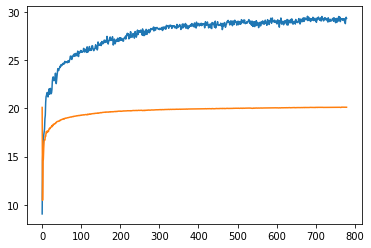

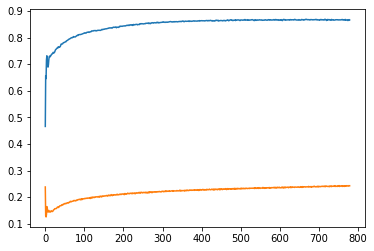

In [38]:
plt.plot(df['val_psnr'])
plt.plot(df['psnr'])
plt.show()
plt.plot(df['val_ssim'])
plt.plot(df['ssim'])

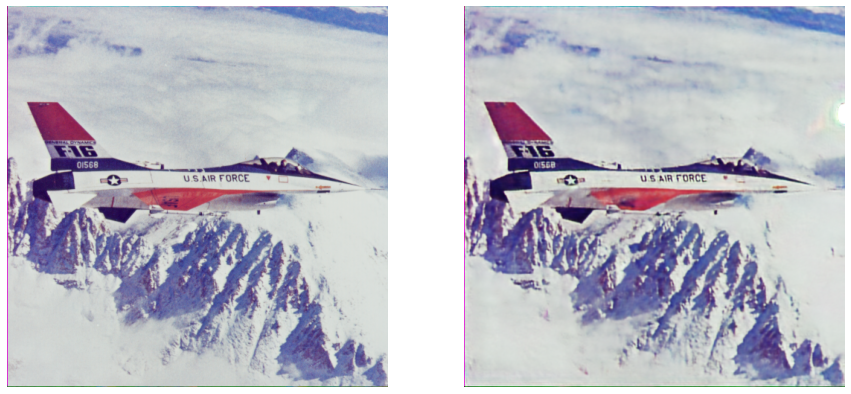

PSNR:  29.364623297910736


In [39]:
out_np = model.predict(net_input)[0]
plot_images([img, out_np])
print("PSNR: ", peak_signal_noise_ratio(img, out_np))

In [40]:
values = model.evaluate(x = net_input,y = y_val)
values, model.metrics_names

1/1 [==============================] - 0s 66ms/step - loss: 0.0012 - psnr: 29.3646 - ssim: 0.8662


([0.0011575445532798767, 29.364622116088867, 0.8662328124046326],
 ['loss', 'psnr', 'ssim'])

In [41]:
values = model.evaluate(x = net_input,y = y)
values, model.metrics_names

1/1 [==============================] - 0s 67ms/step - loss: 0.0098 - psnr: 20.0984 - ssim: 0.2612


([0.009776069782674313, 20.098356246948242, 0.2611670196056366],
 ['loss', 'psnr', 'ssim'])

# Reinit model and load weights

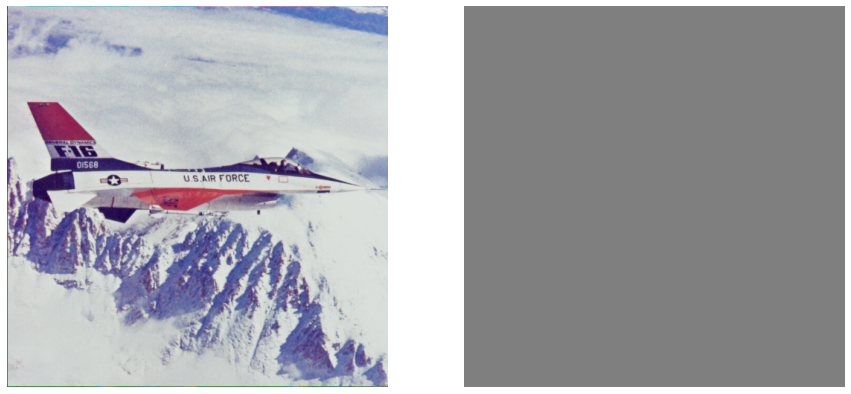

PSNR:  11.221351970920107


In [42]:
# reinit model
model = skip_net()
out_np = model(net_input).numpy()[0]
plot_images([img, out_np])
print("PSNR: ", peak_signal_noise_ratio(img, out_np))

In [43]:
# load weights
model.load_weights('test.hdf5')

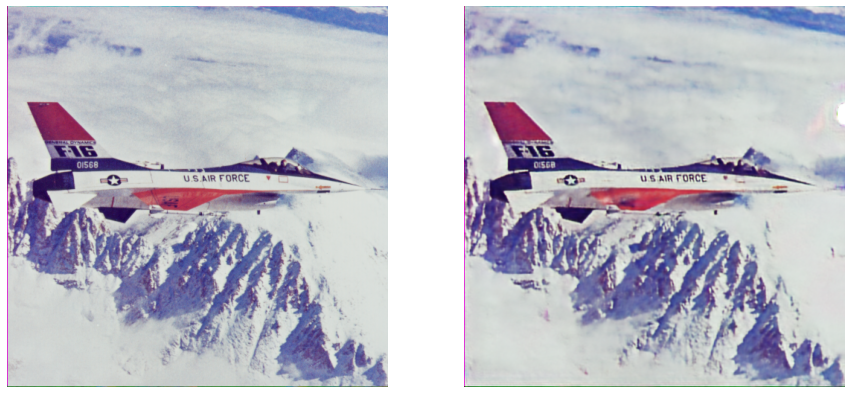

PSNR:  29.589576739413026


In [44]:
out_np = model(net_input).numpy()[0]
plot_images([img, out_np])
print("PSNR: ", peak_signal_noise_ratio(img, out_np))